In [188]:
import matplotlib
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [189]:
import numpy as np
import pandas as pd

In [190]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [191]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [192]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [193]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [194]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [195]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [196]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [197]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Measurement).all()


In [198]:
# Calculate the date 1 year ago from the last data point in the database
import datetime
query_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
prior_year = datetime.datetime.strptime(query_date[0],'%Y-%m-%d').date() - (dt.timedelta(days=365))
print(prior_year)

2016-08-23


In [23]:
# Perform a query to retrieve the data and precipitation scores
data_precip_query = session.query(Measurement.date,Measurement.prcp \
                                 ).filter(Measurement.date >= prior_year \
                                         ).all()
date = [data_precip_query[0] for data_precip_query in data_precip_query]
precip = [data_precip_query[1] for data_precip_query in data_precip_query]
#precip_query = session.query(Measurement.prcp).limit(200).all()                 

In [95]:
# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.DataFrame({"Date":date,"Precip":precip})
data_df.set_index('Date',inplace=True)
# Sort the dataframe by date
data_df=data_df.sort_values(by='Date',ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
data_df.head()

,Precip
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [104]:
%matplotlib inline

<function matplotlib.pyplot.show(*args, **kw)>

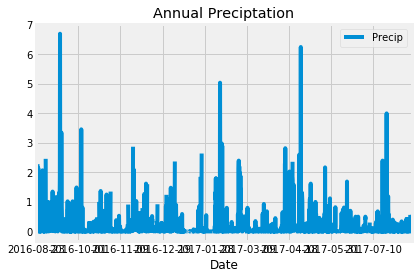

In [105]:
data_df.plot(title="Annual Preciptation")
plt.show

![precipitation](Images/precipitation.png)

In [106]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,Precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [107]:
# Design a query to show how many stations are available in this dataset?
station_query = session.query(Measurement).group_by(Measurement.station).count()
print(station_query)

9


In [108]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_query = session.query(Measurement.station,
    func.count(Measurement.station).label('qty')
    ).group_by(Measurement.station
    ).order_by(desc('qty')).all()
active_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [109]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

In [126]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temps = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter_by(station=active_query[0][0]).all()
print(temps)

[(54.0, 85.0, 71.66378066378067)]


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 53., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

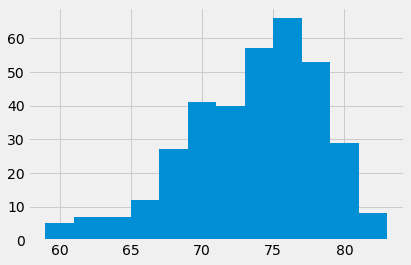

In [211]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
obs_data = session.query(Measurement.tobs
    ).filter_by(station=active_query[0][0]
    ).filter(Measurement.date >= prior_year
    ).all()
obs = [obs_data[0] for obs_data in obs_data]
#num_obs = [max_obs_data[1] for max_obs_data in max_obs_data]
plt.hist(obs,bins=12)

![precipitation](Images/station-histogram.png)

In [112]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [127]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
from_date = datetime.datetime.strptime('2012-02-28','%Y-%m-%d').date()  - dt.timedelta(days=365)
to_date = datetime.datetime.strptime('2012-03-05','%Y-%m-%d').date()  - dt.timedelta(days=365)
trip_temps = calc_temps(start_date,end_date)
trip_df = pd.DataFrame(trip_temps,columns=['Min Temp','Avg Temp','Max Temp'])
trip_df

,Min Temp,Avg Temp,Max Temp
0,61.0,70.089286,75.0


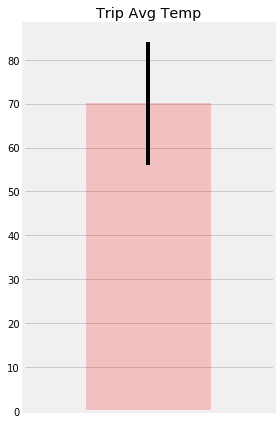

In [152]:
error = trip_df['Max Temp']-trip_df['Min Temp']
trip_df.plot.bar(y='Avg Temp', yerr = error,title="Trip Avg Temp", alpha=0.2, figsize=(4,6),color='red')
plt.xticks(np.arange(1,1.0))
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()

<IPython.core.display.Javascript object>


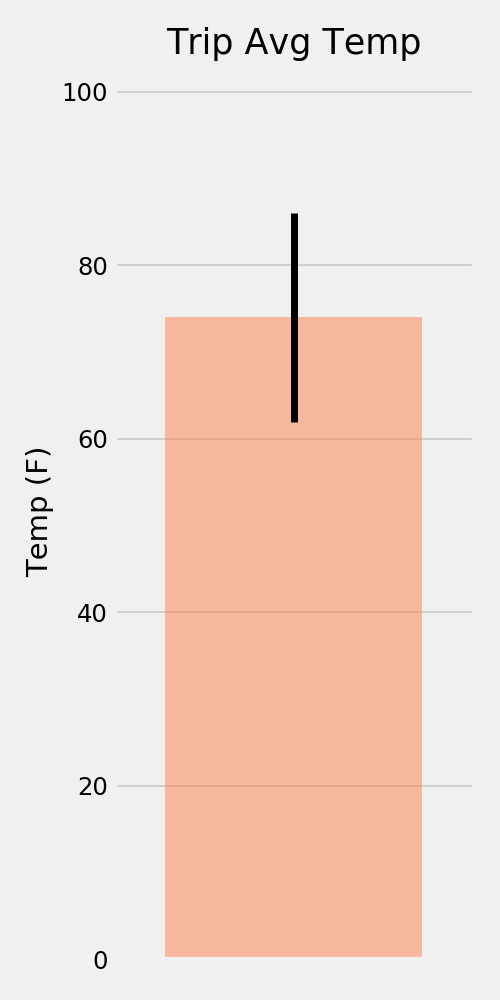

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [125]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
msmt_station = session.query(Measurement.station, Station.name,Station.latitude,Station.longitude,Station.elevation,Measurement.prcp.label('qty')).filter(Measurement.station == Station.station).filter(Measurement.date >= from_date).filter(Measurement.date <= to_date).group_by(Measurement.station).order_by(desc('qty')).all()
print(msmt_station)

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, None)]


In [75]:
print(from_date)

2011-02-28


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [136]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [215]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
from datetime import timedelta,date
# Use the start and end date to create a range of dates
def daterange(date1,date2):
    for n in range(int ((date2-date1).days)+1):
        yield date1 + timedelta(n)
start_date = datetime.datetime.strptime('2012-02-28','%Y-%m-%d').date()
end_date = datetime.datetime.strptime('2012-03-05','%Y-%m-%d').date()

# Stip off the year and save a list of %m-%d strings
days = daterange(start_date, end_date)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for day in days:
    normals.append(daily_normals(func.strftime("%m-%d",day)))
normals

[[(65.0, 70.65517241379311, 80.0)],
 [(67.0, 71.73333333333333, 79.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)]]

In [217]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals[0],columns=['tmin','tavg','tmax'])
normals_df.head()

,tmin,tavg,tmax
0,65.0,70.655172,80.0


<IPython.core.display.Javascript object>


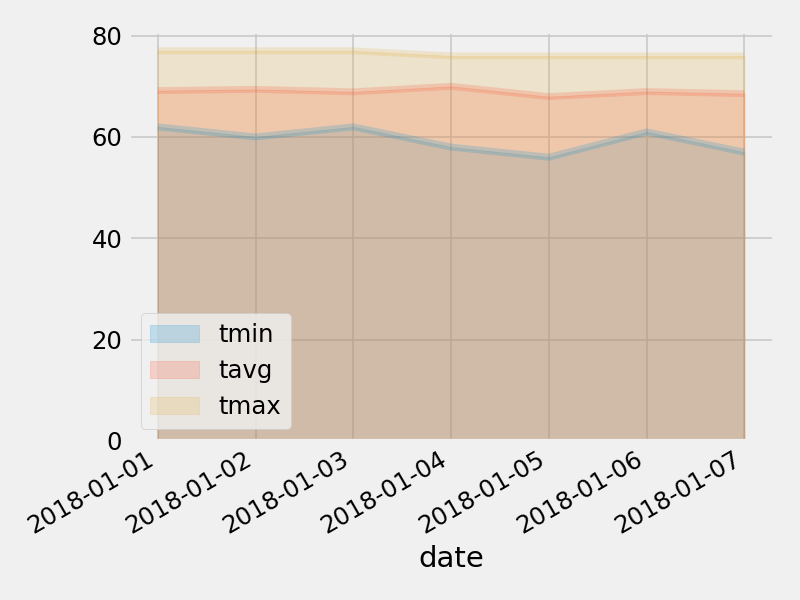

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
